# Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

_This notebook demonstrates the implementation of neural architecture proposed by [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) for image caption generation._


**Note**: This notebook was made as a part of ML course project during my third year (2020) so it may not be properly documented as the other notebooks. I'll try to properly document this notebook in future.
    

The image captioning architecture is divided into sections but broadly the attention mechanism is at the ground level of image captioning models. It is a dynamic technique that works mainly for sequence based modelling. These models are made of an encoder and decoder architecture. The job of the encoder is generating image vectors from the given images. Encoders use convolutional neural networks for performing this task (e.g. vgg16, inceptionV3, resnet50, etc).

Recurrent neural networks (RNNs) are used as decoders. Here the outputs are fed back into the inputs(e.g. LSTMs and GRUs). This encoder-decoder 
architecture is not sufficient enough to handle image captioning as it would fail if long sequences (paragraphs) are given as input. This happens because RNNs cannot hold this much knowledge. Thus the mechanism for attention is added between the decoder and encoder architecture so as to give more focus on the important parts of the image.

Thus the flow here is Resnet101 generated features are applied ReLU activation so as to generate the score (features). Then an activation function (softmax) is applied on these scores to get the required attention weights. Finally the context vector is calculated by multiplying the obtained scores and attention weights. This vector is fed into the decoder where the captions are generated. Beam search is applied to the output generated from the decoder. For every word top ‘n’ suitable candidates are considered and then ‘n’ second words are generated for each of these ‘n’ first words. Then top ‘m’ combinations of these first and second words are selected for further processing. This happens at each decoding sequence. Once the decoding process is completed the sentence formed with the highest score is printed as the required caption. Values of ‘n’, ‘m’ and number of words to be considered can be set by the user.


We will build a neural network model that generates decriptive caption for an image.


We'll use the [MS COCO Dataset](https://cocodataset.org/#download) and [Karpathy's split](https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip) for the task of generation of the image description a.k.a image captioning.


In [1]:
# I added
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# I added
%cd '/content/drive/MyDrive/2022-2023/CS231N'

/content/drive/MyDrive/2022-2023/CS231N


In [ ]:
# %%capture
# !wget http://images.cocodataset.org/zips/train2014.zip
# !unzip 'train2014.zip'
# !rm -r 'train2014.zip'

# !wget http://images.cocodataset.org/zips/val2014.zip
# !unzip 'val2014.zip'
# !rm -r 'val2014.zip'

# !wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
# !unzip 'caption_datasets.zip'
# !rm -r 'caption_datasets.zip'

## Imports

In [4]:
%matplotlib inline
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage.transform
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tqdm'

## Data Preprocessing and Loading


In [98]:
print("# of images [training]: {}".format(len(os.listdir("/content/drive/MyDrive/2022-2023/CS231N/project_toy_data/images/submissions_0"))))
# print("# of images [validation]: {}".format(len(os.listdir("val2014"))))

# of images [training]: 20


In [8]:
from collections improt Counter
import os

SyntaxError: invalid syntax (3262204673.py, line 1)

In [12]:
import pandas as pd
COMMENTS_DIR = 'data/RPCD/photocritique/comments'

In [15]:
# with open('dataset_coco.json', 'r') as f:
#     data = json.load(f)

max_len = 100               # length of padded captions
# image_folder = '/content/drive/MyDrive/2022-2023/CS231N/project_toy_data/images/submissions_0'   # folder with download images for train and val set
min_word_freq = 0           # words occuring less than this threshold will be labelled as <unk>
captions_per_image = 5      # number of captions per image
word_freq = Counter()       # Counter object to find the freq of each word

# generate word map
# for img in data['images']:
#     for c in img['sentences']:
#         # update word frequency
#         word_freq.update(c['tokens'])
for submission in os.listdir(COMMENTS_DIR):
  for csv in os.listdir(os.path.join(COMMENTS_DIR, submission)):
    df = pd.read_csv(os.path.join(COMMENTS_DIR, submission, csv))
    for index, row in df.iterrows():
      comment = row.comment_body.split(' ')
      word_freq.update(comment)

# create word map (dict mapping words to ids with 0 reserved for padding)
words = [word for word in word_freq.keys() if word_freq[word] > min_word_freq]
word2id = {word: id for id, word in enumerate(words, 1)}
word2id['<unk>'] = len(word2id) + 1
word2id['<start>'] = len(word2id) + 1
word2id['<end>'] = len(word2id) + 1
word2id['<pad>'] = 0

# create reverse word map (dict mapping ids to words)
id2word = {value: word for word, value in word2id.items()}

In [16]:
# I added
print(len(word_freq))

20499


In [22]:
image_folder = 'data/RPCD/photocritique/images'

# split the images and captions into train, val and test
train_image_paths = []
train_image_captions = []
train_caption_lens = []

val_image_paths = []
val_image_captions = []
val_caption_lens = []

test_image_paths = []
test_image_captions = []
test_caption_lens = []

# for img in data['images']:
#     captions = []
#     for c in img['sentences']:
#         if len(c['tokens']) <= max_len:
#             captions.append(c['tokens'])
for submission in os.listdir(COMMENTS_DIR):
    for image_num, csv in enumerate(os.listdir(os.path.join(COMMENTS_DIR, submission))):
        captions = []
        df = pd.read_csv(os.path.join(COMMENTS_DIR, submission, csv))
        for index, row in df.iterrows():
            comment = row.comment_body.split(' ')
            if len(comment) <= max_len:
                captions.append(comment)
            
            if len(captions) == 0:
                continue
            
            # sample the captions randomly such that every image has same no of captions
            if len(captions) < captions_per_image:
                captions += [random.choice(captions) for _ in range(captions_per_image - len(captions))]
            else:
                captions = random.sample(captions, k=captions_per_image)
            
            # sanity check
            assert len(captions) == captions_per_image

            # encode and pad captions
            enc_captions = []
            caption_lens = []
            for idx, caption in enumerate(captions):
                enc_caption = [word2id['<start>']] + [word2id.get(word, word2id['<unk>']) for word in caption] + [
                                word2id['<end>']] + [word2id['<pad>']] * (max_len - len(caption))
                
                # find caption length (including start and end token)
                caption_len = len(caption) + 2

                enc_captions.append(enc_caption)
                caption_lens.append(caption_len)

            # get the absolute path of image
            # path = os.path.join(image_folder, img['filepath'], img['filename'])
            path = image_folder + '/' + csv[:6] + '-image.jpeg'

            # add the image path, encoded caption to the list
            # if img['split'] in {'train', 'restval'}:
            #     train_image_paths.append(path)
            #     train_image_captions.append(enc_captions)
            #     train_caption_lens.append(caption_lens)
            # elif img['split'] in {'val'}:
            #     val_image_paths.append(path)
            #     val_image_captions.append(enc_captions)
            #     val_caption_lens.append(caption_lens)
            # elif img['split'] in {'test'}:
            #     test_image_paths.append(path)
            #     test_image_captions.append(enc_captions)
            #     test_caption_lens.append(caption_lens)

            if image_num < 10:
                train_image_paths.append(path)
                train_image_captions.append(enc_captions)
                train_caption_lens.append(caption_lens)
            else:
                val_image_paths.append(path)
                val_image_captions.append(enc_captions)
                val_caption_lens.append(caption_lens)

# sanity check
assert len(train_image_paths) == len(train_image_captions)
assert len(val_image_paths) == len(val_image_captions)
assert len(test_image_paths) == len(test_image_captions)

In [ ]:
# sets device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class CaptionDataset(Dataset):
    def __init__(self, image_paths, captions, caption_lens, split, captions_per_image=5, transform=None):
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        self.image_paths = image_paths
        self.captions = captions
        self.caption_lens = caption_lens
        self.captions_per_image = captions_per_image

        # pytorch transformation pipeline for image (normalizing, etc)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths) * self.captions_per_image
    
    def __getitem__(self, idx):
        # remember the Nth caption belongs to (N // captions_per_image)th image
        img = Image.open(self.image_paths[idx // self.captions_per_image]).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (256, 256))

        # sanity check
        assert img.shape == (256, 256, 3)
        assert np.max(img) <= 255.

        if self.transform is not None:
            img = self.transform(img)
        
        img = np.array(img)
        img = np.transpose(img, (2, 0, 1))
        img = torch.FloatTensor(img / 255.)

        caption = torch.LongTensor(self.captions[idx // self.captions_per_image][idx % self.captions_per_image])
        caption_len = torch.LongTensor([self.caption_lens[idx // self.captions_per_image][idx % self.captions_per_image]])

        if self.split is 'TRAIN':
            return img, caption, caption_len
        else:
            # return all captions per image for validation or testing to find the BLEU-4 scores
            all_captions = torch.LongTensor(self.captions[idx // self.captions_per_image])
            return img, caption, caption_len, all_captions


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
train_dataset = CaptionDataset(train_image_paths, train_image_captions, train_caption_lens, 'TRAIN')
val_dataset = CaptionDataset(val_image_paths, val_image_captions, val_caption_lens, 'VAL')
# test_dataset = CaptionDataset(test_image_paths, test_image_captions, test_caption_lens, 'TEST')

<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Owner\AppData\Local\Temp\ipykernel_19288\1070625283.py:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.split is 'TRAIN':
C:\Users\Owner\AppData\Local\Temp\ipykernel_19288\1070625283.py:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.split is 'TRAIN':
C:\Users\Owner\AppData\Local\Temp\ipykernel_19288\1070625283.py:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.split is 'TRAIN':


NameError: name 'Dataset' is not defined

### Visualize data

In [ ]:
def decode_caption(enc_caption):
    dec_caption = [
        id2word[id]
        for id in caption.numpy()
        if id2word[id] not in ["<start>", "<end>", "<unk>", "<pad>"]
    ]
    return " ".join(dec_caption)

In [24]:
img, caption, caption_len = train_dataset[0]

print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0));

NameError: name 'train_dataset' is not defined

In [ ]:
# img, caption, caption_len, all_captions = val_dataset[0]

# for caption in all_captions:
#     print(decode_caption(caption))
# print()
# plt.imshow(img.permute(1, 2, 0));

In [ ]:
batch_size = 32
workers = 2

# dataloader for train and val set
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=workers, pin_memory=True)

# quick check to see if data is properly loaded or not
images, captions, caption_lens = next(iter(train_loader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])


## Model Architecture


![model architecture](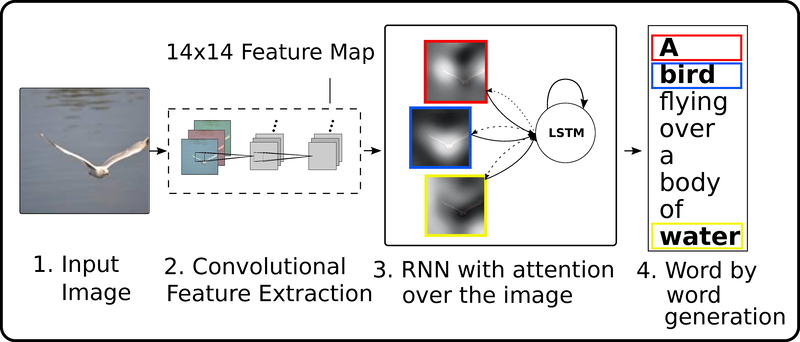 "Model architecture for caption generation")

(source: https://kelvinxu.github.io/projects/capgen.html)

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)

        # remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # resize image to fixed size using adaptive pool to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

        self.fine_tune()

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent computation of the gradients for convolutional blocks 2 through 4 of the image encoder.
        :param fine_tune: boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # if fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune
    
    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return enc_images: encoded repr of images, a tensor of dim (batch_size, enc_image_size, enc_image_size, 2048)
        """
        out = self.resnet(images)       # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)   # (batch_size, 2048, enc_image_size, enc_image_size)
        out = out.permute(0, 2, 3, 1)   # (batch_size, enc_image_size, enc_image_size, 2048)
        return out


In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)   # linear layer to transform encoder's output
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)   # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation (uses Multiplicative attention).
        :param encoder_out: encoded images, a tensor of dim (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dim (batch_size, decoder_dim)
        """
        attn1 = self.encoder_attn(encoder_out)          # (batch_size, num_pixels, attention_dim)
        attn2 = self.decoder_attn(decoder_hidden)       # (batch_size, attention_dim)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))    # (batch_size, num_pixels, 1)

        # apply softmax to calculate weights for weighted encoding based on attention
        alpha = F.softmax(attn, dim=1)                  # (batch_size, num_pixels, 1)
        attn_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha


In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding_size
        :param decoder_dim: feature size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)     # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)                    # embedding layer
        self.dropout = nn.Dropout(p=dropout)

        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True) # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)   # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)    # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)   # linear layer to create a sigmoid-activated gate

        self.fc = nn.Linear(decoder_dim, vocab_size)        # linear layer to find scores over vocabulary
        
        self.init_weights()     # initialize some layers with the uniform distribution
    
    def init_weights(self):
        """
        Initialize some layers with the uniform distribution for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded_images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return hidden_state, cell_state
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch_size, encoder_dim)
        h = self.init_h(mean_encoder_out)   # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)   # (batch_size, decoder_dim)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        batch_size = encoder_out.size(0)

        # flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)     # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # sort the input data by the decreasing caption length
        caption_lens, sort_idx = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        # embedding
        embeddings = self.embedding(encoded_captions)   # (batch_size, max_caption_length, embed_dim)

        # initialize lstm state
        h, c = self.init_hidden_state(encoder_out)      # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are caption lengths - 1
        decode_lens = (caption_lens - 1).tolist()

        # create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # At each time-step, decode by attention-weighing the encoder's output based on the 
        # decoder's previous hidden state output then generate a new word in the decoder with 
        # the previous word and the attention weighted encoding
        for t in range(max(decode_lens)):
            # get the batch size for each time step t
            batch_size_t = sum([l > t for l in decode_lens])

            # get the attention weighted encodings (batch_size_t, encoder_dim)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = F.sigmoid(self.f_beta(h[:batch_size_t]))     # sigmoid gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            # get the decoder hidden state and cell state based on the embeddings of timestep t word 
            # and the attention weighted encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )   # (batch_size_t, decoder_dim)

            # get the next word prediction
            preds = self.fc(self.dropout(h))    # (batch_size_t, vocab_size)

            # save the prediction and alpha for every time step
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
    
        return predictions, encoded_captions, decode_lens, alphas, sort_idx


## Helper Utility functions


In [ ]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
def save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        'epoch': epoch,
        'epochs_since_improvement': epochs_since_improvement,
        'bleu-4': bleu4,
        'encoder': encoder,
        'decoder': decoder,
        'encoder_optimizer': encoder_optimizer,
        'decoder_optimizer': decoder_optimizer
    }
    filename = 'image_captioning_checkpoint_' + str(epoch) + '.pth'
    torch.save(state, filename)
    # store the copy of best checkpoint 
    if is_best:
        print('Saving the best model')
        torch.save(state, 'image_captioning_best.pth')

## Training


In [ ]:
def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """
    losses = []
    top5accs = []

    # train mode (dropout and batchnorm is used)
    decoder.train()
    encoder.train()

    for i, (imgs, caps, cap_lens) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to GPU if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        cap_lens = cap_lens.to(device)

        # forward prop
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

        # since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # remove timesteps that we didn't decode at, or are pads
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # calculate the loss
        loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # backprop
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)
        
        # update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
        
        # keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.append(loss.item())
        top5accs.append(top5)

    return np.mean(losses), np.mean(top5accs)


In [ ]:
def val_epoch(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    losses = []
    top5accs = []

    # eval mode (no dropout or batchnorm)
    decoder.eval()
    if encoder is not None:
        encoder.eval()
    
    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation
    with torch.no_grad():
        for i, (imgs, caps, cap_lens, all_caps) in enumerate(tqdm(val_loader, total=len(val_loader))):
            # move tensor to GPU if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            cap_lens = cap_lens.to(device)
            all_caps = all_caps.to(device) # I added

            # forward prop
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

            # since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # remove timesteps that we didn't decode at, or are pads
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # calculate the loss
            loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # keep track of metrics
            top5 = accuracy(scores, targets, 5)
            losses.append(loss.item())
            top5accs.append(top5)

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # references
            # sort_ind = sort_ind.to(device) # i added bc getting device error
            all_caps = all_caps[sort_ind] # because images were sorted in the decoder
            for j in range(all_caps.shape[0]):
                img_caps = all_caps[j].tolist()
                img_captions = list(
                    map(lambda caption: [word for word in caption if word not in {word2id['<start>'], word2id['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)
            
            # hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, pred in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            hypotheses.extend(temp_preds)
        
            # sanity check
            assert len(references) == len(hypotheses)
        
        # calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
    
    return np.mean(losses), np.mean(top5accs), bleu4


In [ ]:
# model parameters
embed_dim = 512      # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512    # dimension of decoder RNN
encoder_dim = 2048
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
vocab_size = len(word2id)
best_bleu4 = 0.  # BLEU-4 score right now
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0

start_epoch = 1
num_epochs = 1
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU

fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # image_captioning_best.pth
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead


# checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim)
    decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

    encoder = ImageEncoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)

    start_epoch = checkpoint['epoch'] + 1
    best_bleu4 = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    decoder = checkpoint['decoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']

    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr)


encoder = encoder.to(device)
decoder = decoder.to(device)

# lr scheduler
encoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)

# criterion for loss
criterion = nn.CrossEntropyLoss().to(device)

# loop
for epoch in range(start_epoch, num_epochs + 1):
    loss_train, acc_train = train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
    loss_val, acc_val, bleu4_val = val_epoch(val_loader, encoder, decoder, criterion)

    # reduce the learning rate on plateau
    decoder_lr_scheduler.step(bleu4_val)
    if fine_tune_encoder:
        encoder_lr_scheduler.step(bleu4_val)

    # check if there was an improvement
    is_best = bleu4_val > best_bleu4
    best_bleu4 = max(bleu4_val, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
    else:
        epochs_since_improvement = 0
    
    print('-' * 40)
    print(f'epoch: {epoch}, train loss: {loss_train:.4f}, train acc: {acc_train:.2f}%, valid loss: {loss_val:.4f}, valid acc: {acc_val:.2f}%, best BLEU-4: {best_bleu4:.4f}')
    print('-' * 40)
    
    # save the checkpoint
    save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------
epoch: 1, train loss: 4.2956, train acc: 49.14%, valid loss: 4.1134, valid acc: 52.11%, best BLEU-4: 0.1016
----------------------------------------
Saving the best model


## Inference


In [ ]:
def generate_image_caption(encoder, decoder, image_path, word_map, beam_size=5):
    """
    Reads an image and captions it with beam search as well as plot attention maps.
    """
    k = beam_size
    
    # id to word mapping
    rev_word_map = {id: word for word, id in word_map.items()}

    # read and pre-process image
    img = np.array(Image.open(image_path).convert('RGB'))
    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (256, 256))

    # sanity check
    assert img.shape == (256, 256, 3)
    assert np.max(img) <= 255

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = transform(img)    # (3, 256, 256)

    # encode the image
    encoder_out = encoder(img.unsqueeze(0).to(device))     # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # flatten encoded image representation
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # we'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)    # (k, num_pixels, encoder_dim)

    # tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words   # (k, 1)

    # tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # lists to store completed sequences along with their alphas and scores
    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (s, enc_image_size, enc_image_size)

        gate = F.sigmoid(decoder.f_beta(h))      # gating scalar, (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
        )   # (s, decoder_dim)

        scores = decoder.fc(h)      # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # add the scores to prev scores
        scores = top_k_scores.expand_as(scores) + scores    # (s, vocab_size)

        # all the k points will have the same score for the first step (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
        else:
            # unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
        
        # convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)    # (s, step + 1)
        top_k_seqs_alpha = torch.cat(
            [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        )   # (s, step + 1, enc_image_size, enc_image_size)
        
        # which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                            if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())

            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # proceed with incomplete sequences
        if k == 0:
            break
        
        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # break if things have been going on too long
        if step > 50:
            break
        step += 1
    
    # select sequence with max score
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    caption = [rev_word_map[ind] for ind in seq]

    img = Image.open(image_path).convert('RGB')
    img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    # plot the image and attention map
    # fig = plt.figure(figsize=(20, 8))
    # for t in range(len(caption)):
        
    #     plt.subplot(np.ceil(len(caption) / 5.), 5, t + 1)
    #     plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
    #     plt.imshow(img)

    #     current_alpha = alphas[t]
    #     alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
    #     if t == 0:
    #         plt.imshow(alpha, alpha=0)
    #     else:
    #         plt.imshow(alpha, alpha=0.8)
        
    #     plt.set_cmap('gray')
    #     plt.axis('off')

    # plt.show()  
    plt.imshow(img)
    print(caption)

['<start>', '<unk>', '<end>']


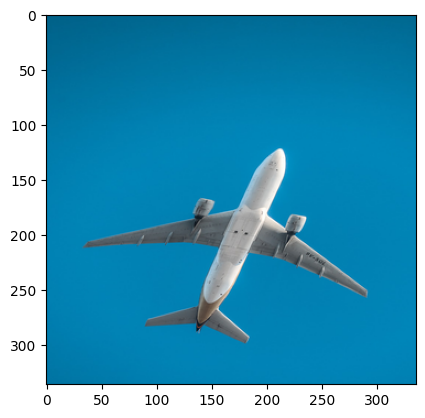

In [ ]:
#@title Generate Caption for an Image

CKPT_PATH = '/content/drive/MyDrive/2022-2023/CS231N/image_captioning_best.pth'

image_url = 'https://images.unsplash.com/photo-1531642765602-5cae8bbbf285?ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8YWVyb3BsYW5lfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80' #@param {type:"string"}
beam_size =  20 #@param {type: "number"}

checkpoint = torch.load(CKPT_PATH, map_location=device)

encoder = checkpoint['encoder']
decoder = checkpoint['decoder']

vocab_size = len(word2id)
image_path = 'picture.png'

from urllib.request import urlretrieve
urlretrieve(image_url, image_path)

generate_image_caption(encoder, decoder, image_path, word2id, beam_size)


## References

1. [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf)
2. [Image Captioning Tutorial by sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)
3. [Image Captioning with visual attention - TensorFlow](https://www.tensorflow.org/tutorials/text/image_captioning)
